In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter, OrderedDict
from matplotlib.lines import Line2D
from torchvision import datasets, models, transforms
from tqdm import trange

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# https://github.com/activatedgeek/LeNet-5/blob/master/lenet.py
class LeNet5(nn.Module):
    def __init__(self, p=0.5):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5), padding=2)),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5), padding=2)),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(1080, 84)),
            ('relu6', nn.ReLU()),
            ('dropout6', nn.Dropout(p)),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [3]:
def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

batch_size = 1

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

ones = []
for x, y in test_loader:
    if y.item() == 1:
        ones.append(x[0][0].numpy())
print('Number of 1 in test data:', len(ones))

Number of 1 in test data: 1135


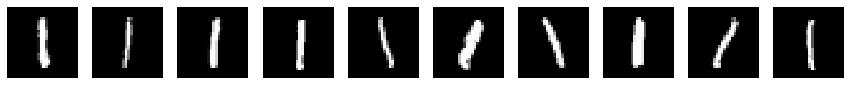

In [4]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=10)
for i in range(10):
    ax[i].imshow(ones[i + 20], cmap='gray')
    ax[i].axis('off')
plt.show()

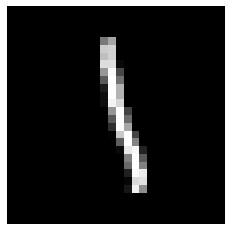

In [5]:
img_one = ones[24]
plt.imshow(img_one, cmap='gray')
plt.axis('off')
plt.show()

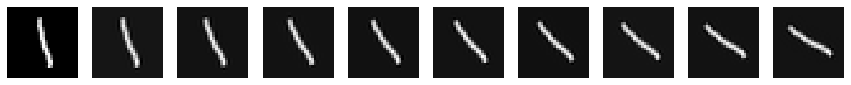

In [6]:
from scipy.ndimage.interpolation import rotate

images_rotated = [rotate(img_one, angle, mode='nearest', reshape=False) for angle in range(0, 60, 5)]
fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=10)
for i in range(10):
    ax[i].imshow(images_rotated[i], cmap='gray')
    ax[i].axis('off')
plt.show()

# Dropout 0.5

In [7]:
model_path = 'models/lenet_dropout_0-5.pt'

model = LeNet5(p=0.5).to(device)
model.load_state_dict(torch.load(model_path))

# turn off dropout
model.eval()

LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=1080, out_features=84, bias=True)
    (relu6): ReLU()
    (dropout6): Dropout(p=0.5, inplace=False)
    (f7): Linear(in_features=84, out_features=10, bias=True)
    (sig7): LogSoftmax()
  )
)

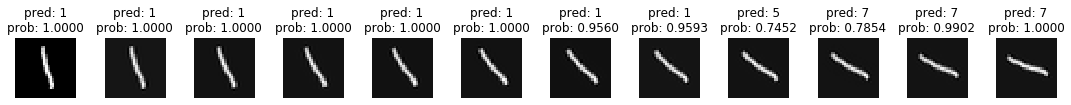

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=12)
for i in range(12):
    ax[i].imshow(images_rotated[i], cmap='gray')
    ax[i].axis('off')
    with torch.no_grad():
        x = torch.tensor(images_rotated[i]).unsqueeze(0).unsqueeze(0).to(device)
        prediction = model(x)
        pred_class = prediction.softmax(1).argmax(1).item()
        prob_class = prediction.softmax(1)[0][pred_class].item()
        ax[i].set_title('pred: {}\nprob: {:.4f}'.format(pred_class, prob_class))
plt.tight_layout()
plt.show()

In [9]:
set_random_seeds(13, device)

# turning on dropout
model.train()

n_passes = 100

softmax_input_values = []
softmax_output_values = []
for i in range(len(images_rotated)):
    preds_softmax_input = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    preds_softmax_output = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    preds_classes = []
    for _ in range(n_passes):
        with torch.no_grad():
            x = torch.tensor(images_rotated[i]).unsqueeze(0).unsqueeze(0).to(device)
            prediction = model(x)
            pred_class = prediction.softmax(1).argmax(1).item()
            preds_classes.append(pred_class)
            y_softmax_input = prediction.cpu().numpy()[0]
            y_softmax_output = prediction.softmax(1).cpu().numpy()[0]
            for j in range(10):
                preds_softmax_input[j].append(y_softmax_input[j])
                preds_softmax_output[j].append(y_softmax_output[j])
    print(i, Counter(preds_classes))
    softmax_input_values.append(preds_softmax_input)
    softmax_output_values.append(preds_softmax_output)

0 Counter({1: 100})
1 Counter({1: 100})
2 Counter({1: 100})
3 Counter({1: 100})
4 Counter({1: 100})
5 Counter({1: 99, 5: 1})
6 Counter({1: 67, 5: 24, 3: 8, 7: 1})
7 Counter({1: 54, 5: 22, 7: 12, 2: 9, 3: 3})
8 Counter({5: 41, 1: 24, 2: 17, 7: 16, 8: 2})
9 Counter({5: 38, 7: 30, 2: 15, 1: 14, 4: 2, 0: 1})
10 Counter({7: 76, 2: 19, 5: 4, 8: 1})
11 Counter({7: 98, 2: 2})


In [10]:
def get_scatter(class_idx, softmax_values):
    x = []
    y = []
    for i in range(len(images_rotated)):
        for j in range(n_passes):
            x.append(i)
            y.append(softmax_values[i][class_idx][j])
    return x, y

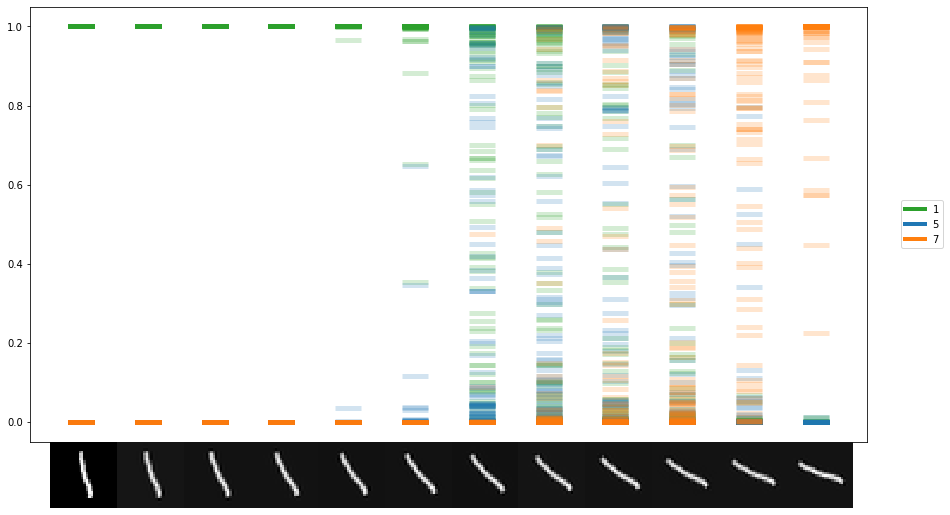

In [11]:
x1_output, y1_output = get_scatter(1, softmax_output_values)
x5_output, y5_output = get_scatter(5, softmax_output_values)
x7_output, y7_output = get_scatter(7, softmax_output_values)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(x1_output, y1_output, marker=1, alpha=0.2, s=700, color='#2ca02c', label='1', linewidth=5)
ax.scatter(x5_output, y5_output, marker=1, alpha=0.2, s=700, color='#1f77b4', label='5', linewidth=5)
ax.scatter(x7_output, y7_output, marker=1, alpha=0.2, s=700, color='#ff7f0e', label='7', linewidth=5)

custom_lines = [Line2D([0], [0], color='#2ca02c', lw=4),
                Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

xl, yl, xh, yh = np.array(ax.get_position()).ravel()

img_size = 0.115

sliding_coef = 0.062

for i in range(len(images_rotated)):
    axis_new = fig.add_axes([xl - img_size * 0.075 + sliding_coef * i, yl - img_size, img_size, img_size])
    axis_new.axison = False
    axis_new.imshow(images_rotated[i], cmap='gray')

ax.legend(custom_lines, [1, 5, 7], bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

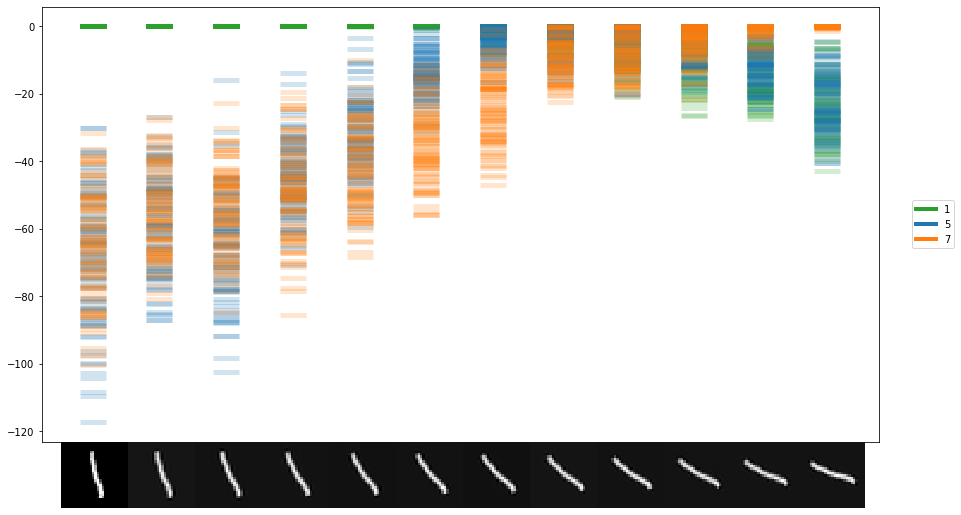

In [12]:
x1_input, y1_input = get_scatter(1, softmax_input_values)
x5_input, y5_input = get_scatter(5, softmax_input_values)
x7_input, y7_input = get_scatter(7, softmax_input_values)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(x1_input, y1_input, marker=1, alpha=0.2, s=700, color='#2ca02c', label='1', linewidth=5)
ax.scatter(x5_input, y5_input, marker=1, alpha=0.2, s=700, color='#1f77b4', label='5', linewidth=5)
ax.scatter(x7_input, y7_input, marker=1, alpha=0.2, s=700, color='#ff7f0e', label='7', linewidth=5)

custom_lines = [Line2D([0], [0], color='#2ca02c', lw=4),
                Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

xl, yl, xh, yh = np.array(ax.get_position()).ravel()

img_size = 0.115

sliding_coef = 0.062

for i in range(len(images_rotated)):
    axis_new = fig.add_axes([xl - img_size * 0.075 + sliding_coef * i, yl - img_size, img_size, img_size])
    axis_new.axison = False
    axis_new.imshow(images_rotated[i], cmap='gray')

ax.legend(custom_lines, [1, 5, 7], bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Dropout 0.25

In [13]:
model_path = 'models/lenet_dropout_0-25.pt'

model = LeNet5(p=0.25).to(device)
model.load_state_dict(torch.load(model_path))

# turn off dropout
model.eval()

LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=1080, out_features=84, bias=True)
    (relu6): ReLU()
    (dropout6): Dropout(p=0.25, inplace=False)
    (f7): Linear(in_features=84, out_features=10, bias=True)
    (sig7): LogSoftmax()
  )
)

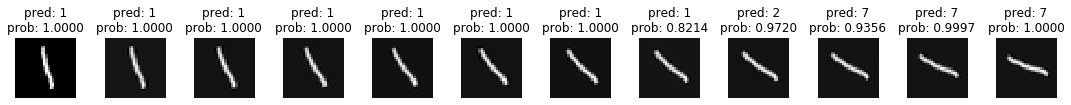

In [14]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=12)
for i in range(12):
    ax[i].imshow(images_rotated[i], cmap='gray')
    ax[i].axis('off')
    with torch.no_grad():
        x = torch.tensor(images_rotated[i]).unsqueeze(0).unsqueeze(0).to(device)
        prediction = model(x)
        pred_class = prediction.softmax(1).argmax(1).item()
        prob_class = prediction.softmax(1)[0][pred_class].item()
        ax[i].set_title('pred: {}\nprob: {:.4f}'.format(pred_class, prob_class))
plt.tight_layout()
plt.show()

In [15]:
set_random_seeds(13, device)

# turning on dropout
model.train()

n_passes = 100

softmax_input_values = []
softmax_output_values = []
for i in range(len(images_rotated)):
    preds_softmax_input = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    preds_softmax_output = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    preds_classes = []
    for _ in range(n_passes):
        with torch.no_grad():
            x = torch.tensor(images_rotated[i]).unsqueeze(0).unsqueeze(0).to(device)
            prediction = model(x)
            pred_class = prediction.softmax(1).argmax(1).item()
            preds_classes.append(pred_class)
            y_softmax_input = prediction.cpu().numpy()[0]
            y_softmax_output = prediction.softmax(1).cpu().numpy()[0]
            for j in range(10):
                preds_softmax_input[j].append(y_softmax_input[j])
                preds_softmax_output[j].append(y_softmax_output[j])
    print(i, Counter(preds_classes))
    softmax_input_values.append(preds_softmax_input)
    softmax_output_values.append(preds_softmax_output)

0 Counter({1: 100})
1 Counter({1: 100})
2 Counter({1: 100})
3 Counter({1: 100})
4 Counter({1: 100})
5 Counter({1: 100})
6 Counter({1: 100})
7 Counter({1: 64, 2: 20, 5: 16})
8 Counter({2: 77, 7: 11, 5: 6, 8: 6})
9 Counter({7: 66, 2: 31, 8: 3})
10 Counter({7: 93, 2: 6, 3: 1})
11 Counter({7: 98, 2: 2})


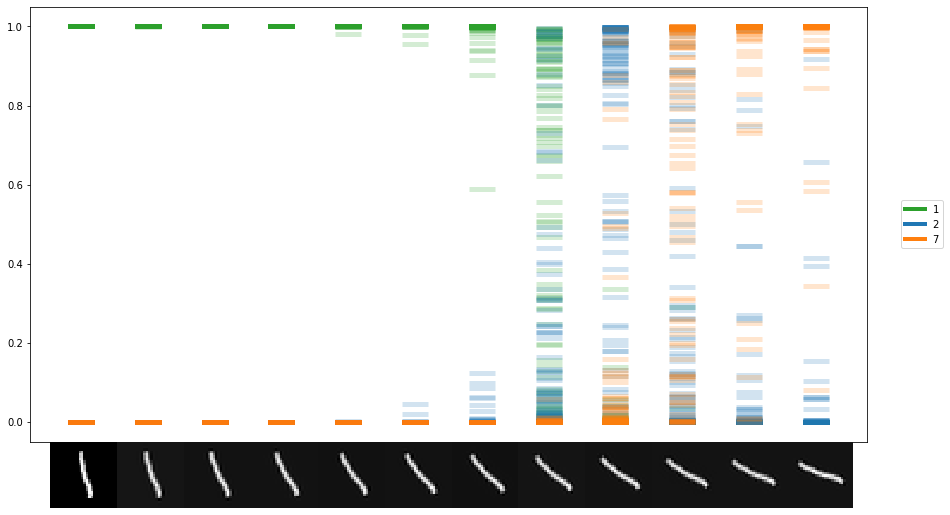

In [16]:
x1_output, y1_output = get_scatter(1, softmax_output_values)
x2_output, y2_output = get_scatter(2, softmax_output_values)
x7_output, y7_output = get_scatter(7, softmax_output_values)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(x1_output, y1_output, marker=1, alpha=0.2, s=700, color='#2ca02c', label='1', linewidth=5)
ax.scatter(x2_output, y2_output, marker=1, alpha=0.2, s=700, color='#1f77b4', label='2', linewidth=5)
ax.scatter(x7_output, y7_output, marker=1, alpha=0.2, s=700, color='#ff7f0e', label='7', linewidth=5)

custom_lines = [Line2D([0], [0], color='#2ca02c', lw=4),
                Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

xl, yl, xh, yh = np.array(ax.get_position()).ravel()

img_size = 0.115

sliding_coef = 0.062

for i in range(len(images_rotated)):
    axis_new = fig.add_axes([xl - img_size * 0.075 + sliding_coef * i, yl - img_size, img_size, img_size])
    axis_new.axison = False
    axis_new.imshow(images_rotated[i], cmap='gray')

ax.legend(custom_lines, [1, 2, 7], bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

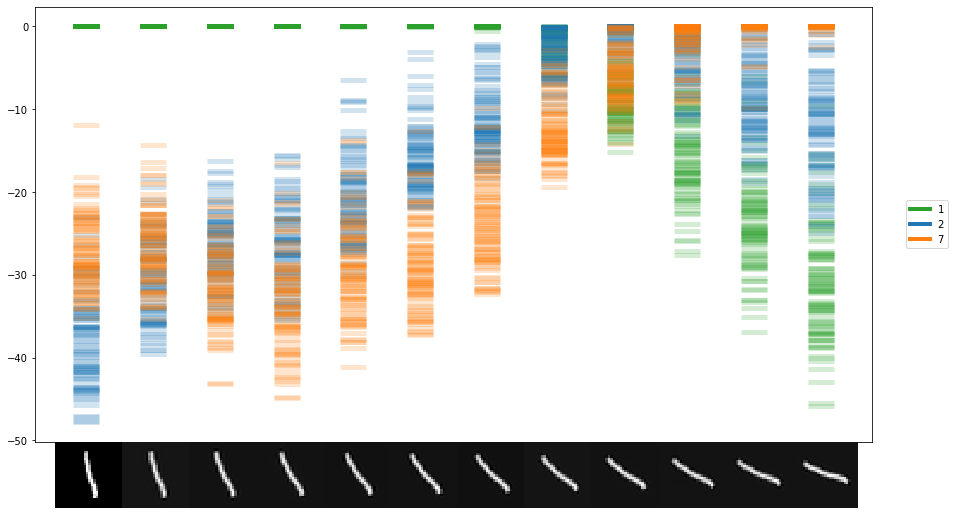

In [17]:
x1_input, y1_input = get_scatter(1, softmax_input_values)
x2_input, y2_input = get_scatter(2, softmax_input_values)
x7_input, y7_input = get_scatter(7, softmax_input_values)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(x1_input, y1_input, marker=1, alpha=0.2, s=700, color='#2ca02c', label='1', linewidth=5)
ax.scatter(x2_input, y2_input, marker=1, alpha=0.2, s=700, color='#1f77b4', label='2', linewidth=5)
ax.scatter(x7_input, y7_input, marker=1, alpha=0.2, s=700, color='#ff7f0e', label='7', linewidth=5)

custom_lines = [Line2D([0], [0], color='#2ca02c', lw=4),
                Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

xl, yl, xh, yh = np.array(ax.get_position()).ravel()

img_size = 0.115

sliding_coef = 0.062

for i in range(len(images_rotated)):
    axis_new = fig.add_axes([xl - img_size * 0.075 + sliding_coef * i, yl - img_size, img_size, img_size])
    axis_new.axison = False
    axis_new.imshow(images_rotated[i], cmap='gray')

ax.legend(custom_lines, [1, 2, 7], bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

# Dropout 0.75

In [18]:
model_path = 'models/lenet_dropout_0-75.pt'

model = LeNet5(p=0.75).to(device)
model.load_state_dict(torch.load(model_path))

# turn off dropout
model.eval()

LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=1080, out_features=84, bias=True)
    (relu6): ReLU()
    (dropout6): Dropout(p=0.75, inplace=False)
    (f7): Linear(in_features=84, out_features=10, bias=True)
    (sig7): LogSoftmax()
  )
)

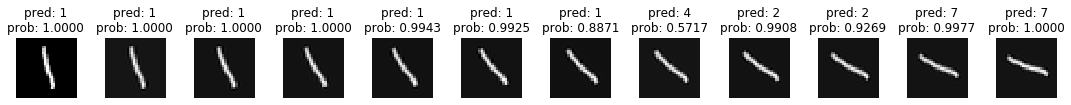

In [19]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=12)
for i in range(12):
    ax[i].imshow(images_rotated[i], cmap='gray')
    ax[i].axis('off')
    with torch.no_grad():
        x = torch.tensor(images_rotated[i]).unsqueeze(0).unsqueeze(0).to(device)
        prediction = model(x)
        pred_class = prediction.softmax(1).argmax(1).item()
        prob_class = prediction.softmax(1)[0][pred_class].item()
        ax[i].set_title('pred: {}\nprob: {:.4f}'.format(pred_class, prob_class))
plt.tight_layout()
plt.show()

In [20]:
set_random_seeds(13, device)

# turning on dropout
model.train()

n_passes = 100

softmax_input_values = []
softmax_output_values = []
for i in range(len(images_rotated)):
    preds_softmax_input = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    preds_softmax_output = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    preds_classes = []
    for _ in range(n_passes):
        with torch.no_grad():
            x = torch.tensor(images_rotated[i]).unsqueeze(0).unsqueeze(0).to(device)
            prediction = model(x)
            pred_class = prediction.softmax(1).argmax(1).item()
            preds_classes.append(pred_class)
            y_softmax_input = prediction.cpu().numpy()[0]
            y_softmax_output = prediction.softmax(1).cpu().numpy()[0]
            for j in range(10):
                preds_softmax_input[j].append(y_softmax_input[j])
                preds_softmax_output[j].append(y_softmax_output[j])
    print(i, Counter(preds_classes))
    softmax_input_values.append(preds_softmax_input)
    softmax_output_values.append(preds_softmax_output)

0 Counter({1: 98, 2: 1, 4: 1})
1 Counter({1: 99, 8: 1})
2 Counter({1: 99, 9: 1})
3 Counter({1: 96, 6: 1, 5: 1, 2: 1, 0: 1})
4 Counter({1: 73, 2: 21, 0: 2, 7: 1, 8: 1, 4: 1, 3: 1})
5 Counter({1: 77, 2: 20, 4: 1, 0: 1, 8: 1})
6 Counter({1: 46, 2: 38, 4: 8, 5: 2, 8: 2, 7: 2, 0: 1, 6: 1})
7 Counter({2: 43, 4: 36, 1: 12, 7: 6, 0: 2, 8: 1})
8 Counter({2: 79, 7: 9, 4: 3, 8: 2, 0: 2, 3: 2, 1: 1, 5: 1, 9: 1})
9 Counter({2: 68, 7: 28, 1: 2, 4: 2})
10 Counter({7: 74, 2: 20, 4: 5, 1: 1})
11 Counter({7: 91, 2: 4, 4: 3, 5: 1, 9: 1})


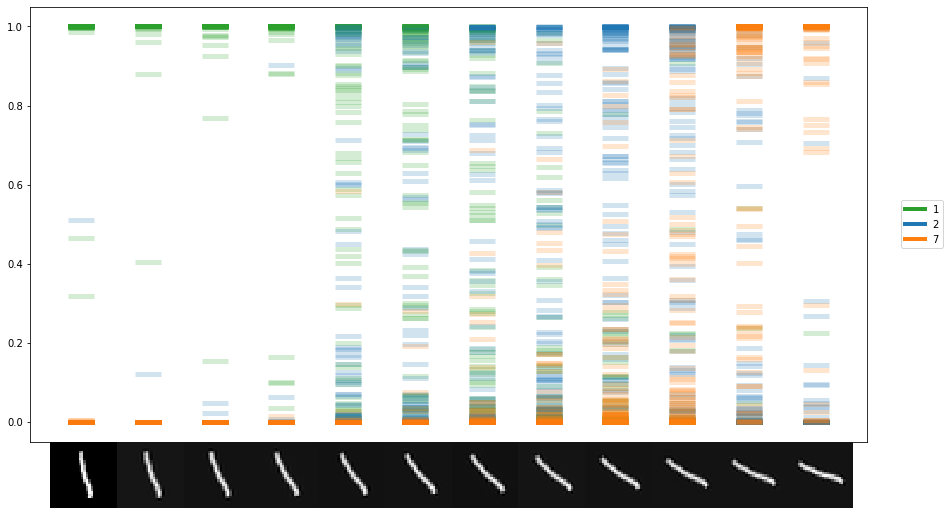

In [21]:
x1_output, y1_output = get_scatter(1, softmax_output_values)
x2_output, y2_output = get_scatter(2, softmax_output_values)
x7_output, y7_output = get_scatter(7, softmax_output_values)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(x1_output, y1_output, marker=1, alpha=0.2, s=700, color='#2ca02c', label='1', linewidth=5)
ax.scatter(x2_output, y2_output, marker=1, alpha=0.2, s=700, color='#1f77b4', label='2', linewidth=5)
ax.scatter(x7_output, y7_output, marker=1, alpha=0.2, s=700, color='#ff7f0e', label='7', linewidth=5)

custom_lines = [Line2D([0], [0], color='#2ca02c', lw=4),
                Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

xl, yl, xh, yh = np.array(ax.get_position()).ravel()

img_size = 0.115

sliding_coef = 0.062

for i in range(len(images_rotated)):
    axis_new = fig.add_axes([xl - img_size * 0.075 + sliding_coef * i, yl - img_size, img_size, img_size])
    axis_new.axison = False
    axis_new.imshow(images_rotated[i], cmap='gray')

ax.legend(custom_lines, [1, 2, 7], bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

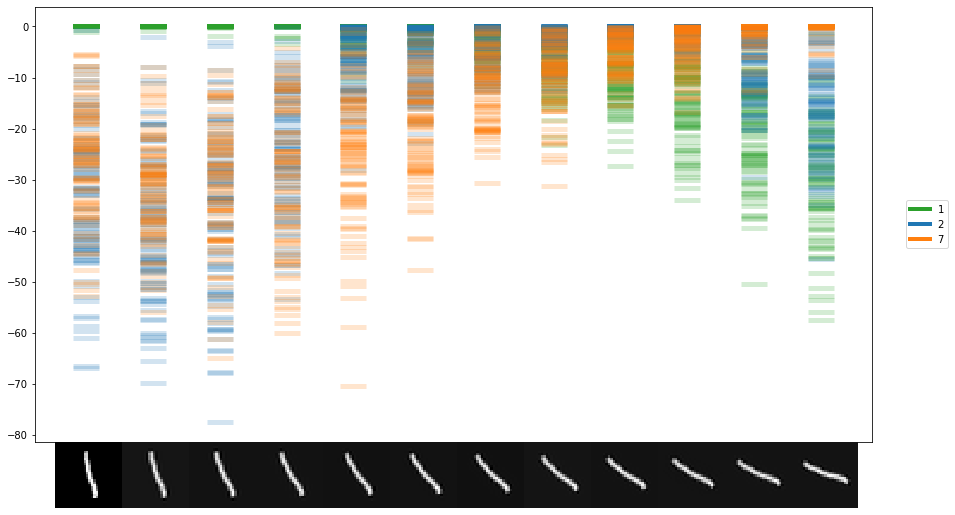

In [22]:
x1_input, y1_input = get_scatter(1, softmax_input_values)
x2_input, y2_input = get_scatter(2, softmax_input_values)
x7_input, y7_input = get_scatter(7, softmax_input_values)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(x1_input, y1_input, marker=1, alpha=0.2, s=700, color='#2ca02c', label='1', linewidth=5)
ax.scatter(x2_input, y2_input, marker=1, alpha=0.2, s=700, color='#1f77b4', label='2', linewidth=5)
ax.scatter(x7_input, y7_input, marker=1, alpha=0.2, s=700, color='#ff7f0e', label='7', linewidth=5)

custom_lines = [Line2D([0], [0], color='#2ca02c', lw=4),
                Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

xl, yl, xh, yh = np.array(ax.get_position()).ravel()

img_size = 0.115

sliding_coef = 0.062

for i in range(len(images_rotated)):
    axis_new = fig.add_axes([xl - img_size * 0.075 + sliding_coef * i, yl - img_size, img_size, img_size])
    axis_new.axison = False
    axis_new.imshow(images_rotated[i], cmap='gray')

ax.legend(custom_lines, [1, 2, 7], bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()